In [ ]:
!pip install deap

     |████████████████████████████████| 153kB 8.5MB/s 


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter,MultipleLocator
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from  sklearn.preprocessing  import MinMaxScaler,StandardScaler
import math


from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

from scipy.spatial import distance
from scipy.linalg import norm


np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive



# Fuzzy C-Means Code Implementation


In [ ]:
class FuzzyClusteringValidatityMetrics:
      """
      Some validity metrics for Fuzzy C-Means:

      Partition Coefficient: Measures 'fuzziness' in partitioned clustering.
      
      Partition Entropy: Measures entropy in partitioned clustering.

      """

      def __init__(self):
        self.__fpc = None
        self.__fpe = None
        self.__gSil_items = None
        self.__gSil = None

        self.u_membership = None

      def fpc(self, u_membership: np.array = None):
            """
            Fuzzy partition coefficient relative to fuzzy c-partitioned
            membership matrix. Measures 'fuzziness' in partitioned clustering.
            
            Parameters:

            u_membership (2D numpy.array): Fuzzy membership matrix (n x c) where
            n = number of data points and c = number of clusters.

            Returns:

            fpc (float): Fuzzy partition coefficient.
            """
            if(self.__fpc is not None and u_membership is None):
              return self.__fpc
            n_data_points = np.float(u_membership.shape[0])
            self.__fpc = (u_membership ** 2).sum() / n_data_points
            return self.__fpc

      def fpe(self, u_membership: np.array = None):
            """
            Fuzzy partition entropy relative to fuzzy c-partitioned
            membership matrix.
            
            Parameters:

            u_membership (2D numpy.array): Fuzzy membership matrix (n x c) where
            n = number of data points and c = number of clusters.

            Returns:

            fpe (float): Fuzzy partition entropy.
            """
            if(self.__fpe is not None and u_membership is None):
              return self.__fpe
            n_data_points = np.float(u_membership.shape[0])
            self.__fpe = (u_membership * np.log(u_membership)).sum()/(-n_data_points)
            return self.__fpe

      def __calculate_parwise_minimum(self, u_membership, sample, reference_pair,n_samples):
          pairwise_minimum =  np.tile(np.expand_dims(sample, axis=1),n_samples).T
          pairwise_minimum = np.minimum(pairwise_minimum,u_membership)
          pairwise_minimum[reference_pair,:] = 0
          return pairwise_minimum

      def __calculate_minimum_score_weighted_mean(self, parwise_minimum,pairwise_distance):
          numerator = (parwise_minimum * pairwise_distance).sum(axis=0)
          denominator = parwise_minimum.sum(axis=0)
          denominator[denominator == 0] = np.nan
          return numerator / denominator

      def generalized_silhouette(self, u_membership = None,X: np.array = None):
          
          """
          Generalized Silhouette measure for fuzzy partitions.
          (Rawashdeh & Ralescu) 2012.
          Parameters:

          X (2D array): matrix of datapoints (n x k) where
          n = number of data points and k = number of dimensions.

          u_membership (2D numpy.array): Fuzzy membership matrix (n x c) where
          n = number of data points and c = number of clusters.

          Returns:

          gSil (float): generalized silhouette coefficient.
          """    
          if(self.__gSil is not None and u_membership is None and X is None):
              return self.__gSil
          if(self.__gSil is None and (u_membership is None or X is None)):
            return -2

          if(type(u_membership) == pd.DataFrame):
            u_membership = u_membership.values

          a = []
          b = []          
          n_clusters = u_membership.shape[1]
          n_samples = u_membership.shape[0]

          pairwise_distance = distance.cdist(X,X)
          u_membership_shifted = np.roll(u_membership,-1,axis=1)

          for index,sample in enumerate(u_membership):
              inter_dist_1 =  self.__calculate_parwise_minimum(u_membership_shifted,sample,index,n_samples)
              inter_dist_2 =  self.__calculate_parwise_minimum(u_membership,np.roll(sample,-1),index,n_samples)
              inter_distance = np.maximum(inter_dist_1,inter_dist_2)

              intra_distance = self.__calculate_parwise_minimum(u_membership,sample,index,n_samples)

              dist_k = pairwise_distance[:,index]
              dist_k = np.tile(np.expand_dims(dist_k, axis=1),n_clusters)
              
              a.append(self.__calculate_minimum_score_weighted_mean(intra_distance,dist_k))
              b.append(self.__calculate_minimum_score_weighted_mean(inter_distance,dist_k))

          a = np.nanmin(a,axis=1)
          b = np.nanmin(b,axis=1)
          self.__gSil_items = (b - a) / np.maximum(b,a)
          self.__gSil = self.__gSil_items.mean()
          return self.__gSil

      def all(self, u_membership: np.array,X):
          self.fpc(u_membership)
          self.fpe(u_membership)
          self.generalized_silhouette(u_membership,X)
          

In [ ]:
import numpy as np
from scipy.spatial import distance
from scipy.linalg import norm
# from fuzzy_validity_metrics import FuzzyClusteringValidatityMetrics

class FuzzyCMeans:
      """
      Fuzzy C-Means implementation based on  J. C. Bezdek, 
      Pattern Recognition with Fuzzy Objective Function Algorithms (1981).
      <https://doi.org/10.1007/978-1-4757-0450-1>

      """
      def __init__(self,random_state = None,m = 2,n_clusters = 10):

            self.random_state = random_state
            if(random_state is not None):
              random = np.random.RandomState(random_state)
            else:
              random = np.random.RandomState()
            self.random = random
            self.m = m
            self.n_clusters = n_clusters
            self.n_dim = None
            self.u_initial, self.centroids_initial = None, None
            self.u_membership, self.centroids = None, None
            self.validity_metrics, self.n_data_points  =None, None

      def initialize_u_membership(self):

            """
            Initialize membership matrix U where the sum of lines is equal to 1.

            Parameters:
             ------x------

            Returns:

            u_membership (np.array): fuzzy membership matrix (n x c) where
            n = number of data points and c = number of clusters.

            """
            random_matrix = self.random.rand(self.n_data_points,self.n_clusters)
            return random_matrix / np.tile(np.reshape(random_matrix.sum(axis=1),(self.n_data_points,1)),self.n_clusters)
            
      def calculate_cluster_centroids(self, u_membership_input: np.array,data_points: np.array):
            """
            Calculate centroids for each cluster based on data points and current 
            membership matrtix.

            Parameters:

            data_points (2D numpy.array): matrix of datapoints (n x k) where
            n = number of data points and k = number of dimensions.

            u_membership_input (2D numpy.array): fuzzy membership matrix (n x c) where
            n = number of data points and c = number of clusters.

            m (float): fuzzy coefficient

            Returns:

            centroids (np.array): calculated centroids for c number of clusters.

            """

            u_membership = u_membership_input**self.m
            numerator = np.dot(u_membership.T,data_points)

            denominator = np.reshape((u_membership).sum(axis=0), (self.n_clusters,1))
            denominator = np.tile(denominator,self.n_dim)

            self.centroids =  numerator / denominator
            return self.centroids

      def calculate_membership_matrix(self, data_points: np.array, centroids:np.array):
            
            """
            Calculate membership matrix based on current centroids, data points 
            and fuzzy coefficient.

            Parameters:

            data_points (2D numpy.array): matrix of datapoints (n x k) where
            n = number of data points and k = number of dimensions.

            centroids (np.array): calculated centroids for c number of clusters.

            """
            if (np.float(self.m) <= 1.02):
              print(self.m)
              self.m = 1.02

            distance_to_centroids_matrix = distance.cdist(data_points,centroids)

            inv_dist = distance_to_centroids_matrix**(-1)
            numerator = inv_dist ** (2/(self.m - 1))

            denominator = (inv_dist ** (2/(self.m - 1))).sum(axis=1) 
            denominator = np.tile(np.reshape(denominator,(self.n_data_points,1)),self.n_clusters)
            u_membership = numerator / denominator
            return u_membership


      def fit(self, dataset: np.array, n_clusters: int, max_iterations = 1000,tolerance = 0.000001,verbose = 0):
          
            """
            Execute the FCM algorithm.

            Parameters:

            data (2D numpy.array): dataset (n x k) where
            n = number of data points and k = number of dimensions.
            
            n_clusters (int): number of clusters to partition the dataset

            max_iterations (int): maximum number of iterations.

            tolerance (float): minimum tolerance to stop iterations.

            u_membership (2D numpy.array): fuzzy membership matrix (n x c) where
            
            m (float): fuzzy coefficient
            """
            self.n_clusters = n_clusters
            self.n_data_points = dataset.shape[0]
            self.n_dim = dataset.shape[1]

            self.u_initial = self.initialize_u_membership()
            self.centroids_initial = self.calculate_cluster_centroids(
                                      u_membership_input = self.u_initial,
                                      data_points = dataset)

            u_current_state = self.u_initial.copy()
            for iteration in range(1,max_iterations):    
                
                if(verbose >= 1):
                  print('Iteration: %.0f ' % iteration)

                centroids = self.calculate_cluster_centroids(u_membership_input = u_current_state,data_points = dataset)
                u_next_state = self.calculate_membership_matrix(data_points = dataset,centroids = centroids)
                
                current_tolerance = norm(u_next_state - u_current_state)
                u_current_state = u_next_state

                if (current_tolerance < tolerance):
                  break
            self.u_membership = u_current_state
            self.centroids = centroids
            self.validity_metrics = FuzzyClusteringValidatityMetrics()
            self.validity_metrics.all(self.u_membership,dataset)
            if(verbose >= 1):
              print('')
              print('Centroids : ')
              print(centroids)
              print('')
              print('Validity Measures : ')
              print('Fuzzy Partition Coefficient: %.4f' % self.validity_metrics.fpc())
              print('Fuzzy Partition Entropy: %.4f' % self.validity_metrics.fpe())
              print('Generalized Silhouette: %.4f' % self.validity_metrics.generalized_silhouette())



# PSO Optimization Code Implementation

In [ ]:
def fcm_clustering():
    fcm = FuzzyCMeans(m=m,n_clusters=n_clusters)
    fcm.fit(dataset=X,n_clusters=n_clusters,tolerance=0.0001,verbose=0,max_iterations=500)
    return fcm

def calculate_fitness_by_centroids(centroids):
    u_membership = calculate_membership_matrix(X,centroids)
    dist_matrix = distance.cdist(X,centroids)
    J = (u_membership**m * dist_matrix).sum()
    return (1/J,)

def calculate_membership_matrix(data_points: np.array, centroids:np.array):

    distance_to_centroids_matrix = distance.cdist(data_points,centroids)

    inv_dist = distance_to_centroids_matrix**(-1)
    numerator = inv_dist ** (2/(m - 1))

    denominator = (inv_dist ** (2/(m - 1))).sum(axis=1) 
    denominator = np.tile(np.reshape(denominator,(data_points.shape[0],1)),centroids.shape[0])
    u_membership = numerator / denominator
    return u_membership

def generate(size, pmin, pmax, smin, smax):
    fcm = fcm_clustering()
    part = creator.Particle(fcm.centroids) 
    speed = np.random.uniform(smin,smax,size)
    part.speed = speed
    part.smin = smin
    part.smax = smax
    return part

def updateParticle(part, best, phi1, phi2):
    u1 = np.random.uniform(0, phi1, np.shape(part))
    u2 = np.random.uniform(0, phi2, np.shape(part))
    v_u1 = u1 * (part.best - part)
    v_u2 = u2 * (best - part)
    part.speed += v_u1 + v_u2
    part += part.speed

def pso_optimization(size): 
    toolbox = base.Toolbox()
    toolbox.register("particle", generate,size=size,pmin=0,pmax=1, smin=-1, smax=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.particle)
    toolbox.register("update", updateParticle, phi1=1, phi2=1)
    toolbox.register("evaluate",calculate_fitness_by_centroids)

    pop = toolbox.population(n=population)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields
    best = None
    iter_no_change = 0
    
    for g in range(GEN):
        iter_no_change += 1
        for part in pop:
            part.fitness.values = toolbox.evaluate(part)
            if part.best is None or part.best.fitness < part.fitness:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            if best is None or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
                iter_no_change = 0
        for part in pop:
            toolbox.update(part, best)
        if iter_no_change >= 50:
          print('converged at generation ',g)
          break
        logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
    # print('best particle')
    # print(best)
    # print('')
    return pop, logbook, best

Some mandatory parameters for PSO

In [ ]:
w = 1
GEN = 150
population = 10
creator.create("FitnessMax", base.Fitness, weights=(w,))
creator.create("Particle", np.ndarray, fitness=creator.FitnessMax, speed=list, 
    smin=None, smax=None, best=None)


#Importing dataset


In [ ]:
df_import = pd.read_excel('drive/My Drive//Colab Notebooks//datasets//InputSAS_Clusterizacao_corrigido.xlsx')
clustering_columns = ['PC_VRAM',	'PLUV',	'PC_ERMT_3F',	'PC_NUC_AD',	'CM_NUC_RES',	'NUC_IND',	'NUC_COM'	]

# Pre-processing

Removing NaNs and switiching strings to upper case

In [ ]:
df_import.dropna(inplace=True)
df_import['Distribuidora'] = [x.upper() for x in df_import['Distribuidora']]
df_import['Conjunto'] = [x.upper() for x in df_import['Conjunto']]
df_import['DistribuidoraConjunto'] = [x.upper() for x in df_import['DistribuidoraConjunto']]
print('Data shape: ',df_import.shape)

Data shape:  (3045, 26)


Removing Underground Assemblies

In [ ]:
df_aerial = df_import[ (df_import['Padrao'] != 3) & (df_import['Padrao'] != 4)]
print('Data shape: ',df_aerial.shape)

Data shape:  (3016, 26)


Normalizing numerical data

In [ ]:
def normalizeData(dataframe, scaler):
    columns = [i for i in dataframe]
    dataframe_norm = scaler.fit_transform(pd.DataFrame(dataframe))
    dataframe_norm  = pd.DataFrame(dataframe_norm, index=dataframe.index,columns=columns)
    return dataframe_norm,scaler

In [ ]:
df_aerial_norm = df_aerial.copy()
df_aerial_norm[clustering_columns],scaler =  normalizeData(df_aerial[clustering_columns],MinMaxScaler())
df_aerial_norm[clustering_columns].describe()

,PC_VRAM,PLUV,PC_ERMT_3F,PC_NUC_AD,CM_NUC_RES,NUC_IND,NUC_COM
count,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000
mean,0.225117,0.464006,0.655875,0.843502,0.139182,0.046725,0.085841
std,0.250794,0.128697,0.290031,0.170991,0.070916,0.074630,0.087478
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.034355,0.420593,0.385393,0.749228,0.090710,0.009341,0.027224
50%,0.112436,0.464030,0.687091,0.898671,0.134011,0.022952,0.058776
75%,0.360643,0.521260,0.961170,0.984440,0.179800,0.051775,0.115366
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Visualizing distribution of variables

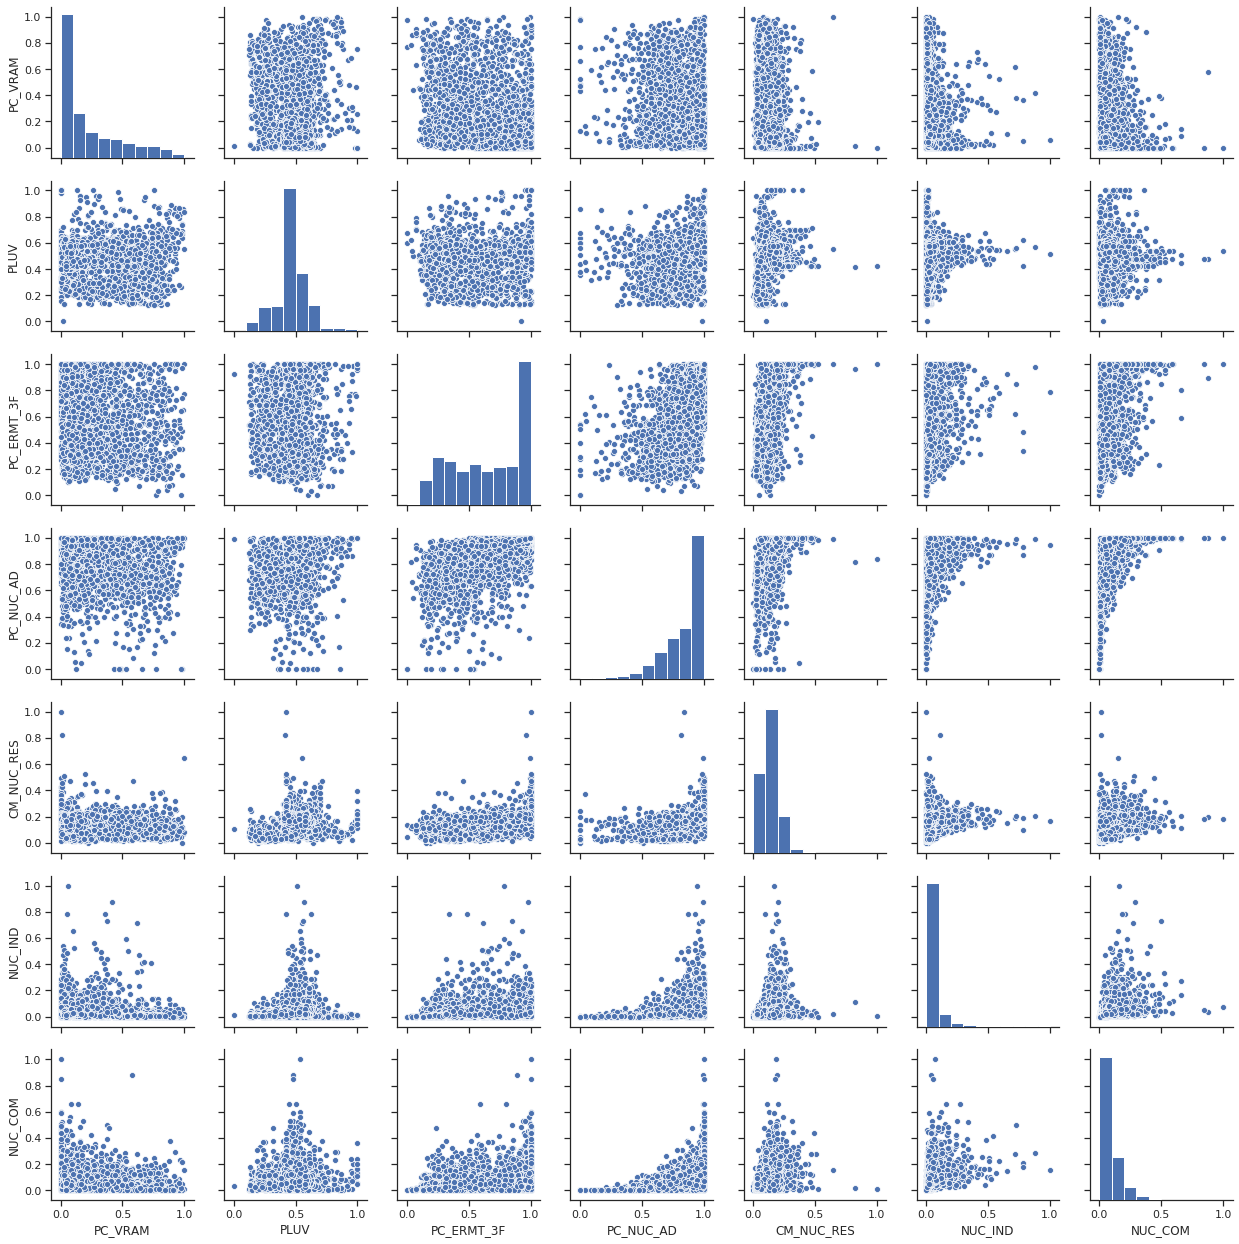

In [ ]:
sns.set(style="ticks")
sns.pairplot(df_aerial_norm[clustering_columns])

Defining minimum and maximum number os cluster per regions of Brazil

In [ ]:
dec_columns = ['PC_VRAM',	'PLUV',	'PC_ERMT_3F',	'PC_NUC_AD',	'CM_NUC_RES',	'NUC_IND']
fec_columns = ['PC_VRAM',	'PLUV',	'PC_ERMT_3F',	'PC_NUC_AD',	'CM_NUC_RES', 'NUC_COM']
regions = np.sort(df_aerial_norm['Regiao'].unique())
indicator_columns = {
    'DEC': dec_columns,
    'FEC': fec_columns
}
max_number_clusters = [];
datasets_by_region = [];

for region in regions:
    print('Region: ', region)
    df_to_cluster = df_aerial_norm[df_aerial_norm['Regiao'] == region]
    number_assemblies = df_to_cluster.shape[0]
    max_clusters = (number_assemblies//30)
    max_clusters = max_clusters if max_clusters <= 20 else 20
    print('Number of assemblies: ',number_assemblies)
    print('Maximum number of clusters: ', max_clusters)
    print('')

    max_number_clusters.append(max_clusters)
    datasets_by_region.append(df_to_cluster)

Region:  CO
Number of assemblies:  325
Maximum number of clusters:  10

Region:  NE
Number of assemblies:  748
Maximum number of clusters:  20

Region:  NO
Number of assemblies:  275
Maximum number of clusters:  9

Region:  SE
Number of assemblies:  1227
Maximum number of clusters:  20

Region:  SU
Number of assemblies:  441
Maximum number of clusters:  14



In [ ]:
def plot_metrics_by_clusters(metrics,clusters,coefficient,title):
  plt.style.use('seaborn-whitegrid')  
  fig,ax = plt.subplots(1,1,figsize=(8,6))
  plt.ylabel(coefficient)
  plt.xlabel('Number of Clusters')
  plt.title(title)
  plt.plot(clusters,metrics, marker='o', linestyle='dashed',linewidth = 1.5)
  plt.grid(True)
  ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
  ax.xaxis.set_major_locator(MultipleLocator(1))
  plt.show()


# DEC - Running clustering for different fuzzy coefficients and number of clusters 

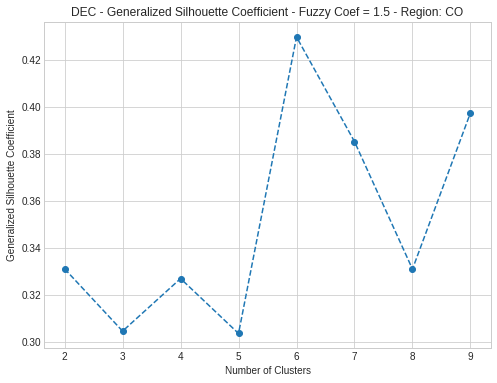

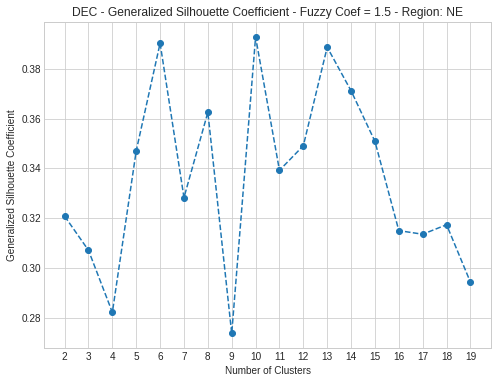

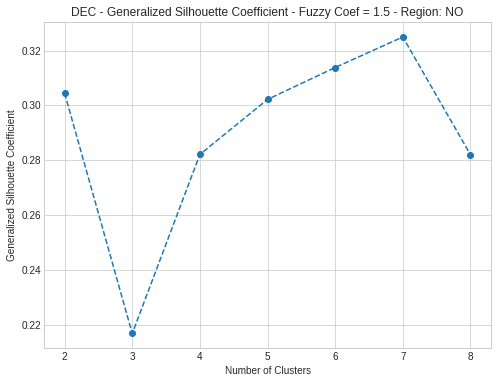

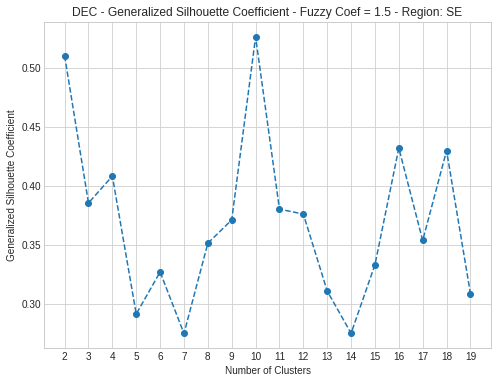

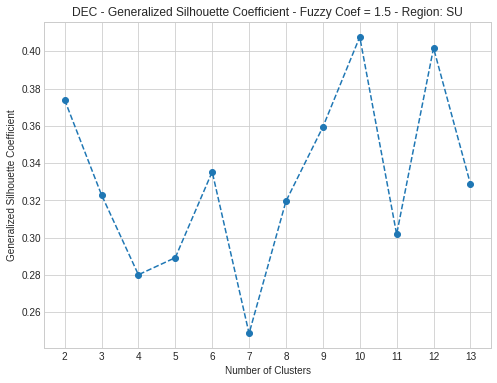

In [ ]:
m_values = [1.5]
n_dim = 6

df_dec_clusters_by_region = pd.DataFrame(columns = regions,index = m_values)
df_dec_optimal_gsils_by_region = pd.DataFrame(columns = regions,index = m_values)

region_result = [
{region:'CO','results':[]},
{region:'NE','results':[]},
{region:'NO','results':[]},
{region:'SE','results':[]},
{region:'SU','results':[]}
]

metric_labels = ['Generalized Silhouette','Fuzzy Partition Coefficient','Fuzzy Partition Entropy']
for m in m_values:
  for index,region in enumerate(regions):
    reg_result = region_result[index]
    cluster_input_data = datasets_by_region[index][indicator_columns['DEC']].values
    X = cluster_input_data
    range_of_clusters = np.arange(2,max_number_clusters[index])
    gsils = [];
    params = []
    
    for n_clusters in range_of_clusters:
        size = (n_clusters,n_dim)
        _,_,best =  pso_optimization(size)
        u_membership = calculate_membership_matrix(centroids=best,data_points=X)
        param = {'centers': best,'clusters':n_clusters,'gSil':-1}
        param['gSil'] = FuzzyClusteringValidatityMetrics().generalized_silhouette(u_membership,X)
        params.append(param)
        # fcm = FuzzyCMeans(m=m,random_state=42)
        # fcm.fit(dataset=cluster_input_data,n_clusters=number_cluster,tolerance=tol,verbose=0,max_iterations=max_iterations)
        gsils.append(param['gSil'])
    reg_result['results'] = params
    plot_metrics_by_clusters(gsils,range_of_clusters,'Generalized Silhouette Coefficient',f'DEC - Generalized Silhouette Coefficient - Fuzzy Coef = {m} - Region: {region}')
    print('')
    df_dec_clusters_by_region.loc[m,region] = range_of_clusters[np.argmax(gsils)]
    df_dec_optimal_gsils_by_region.loc[m,region] = gsils[np.argmax(gsils)]



# FEC - Running clustering for different fuzzy coefficients and number of clusters 

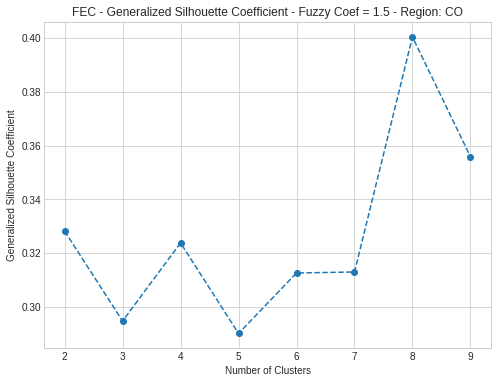

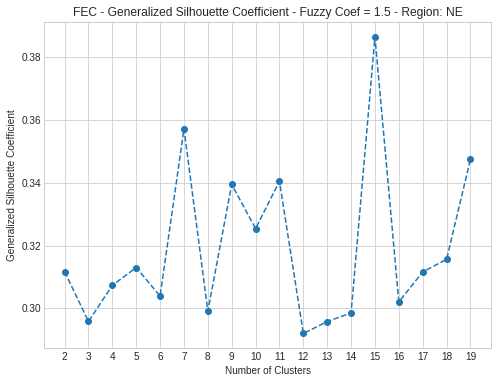

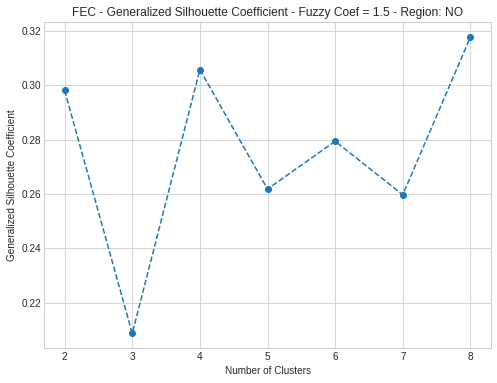

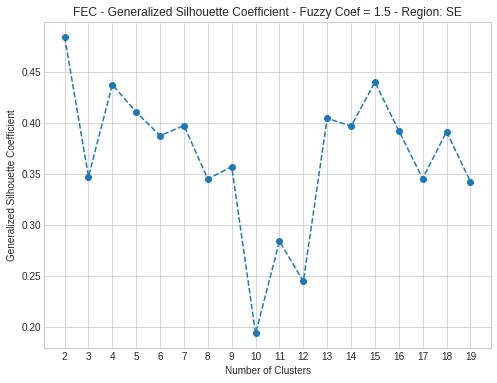

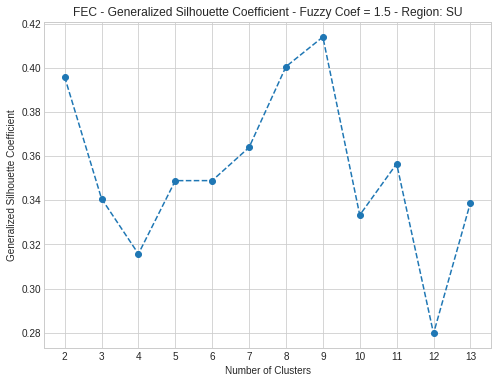

In [ ]:
m_values = [1.5]
n_dim = 6

df_fec_clusters_by_region = pd.DataFrame(columns = regions,index = m_values)
df_fec_optimal_gsils_by_region = pd.DataFrame(columns = regions,index = m_values)


region_result_fec = [
{region:'CO','results':[]},
{region:'NE','results':[]},
{region:'NO','results':[]},
{region:'SE','results':[]},
{region:'SU','results':[]}
]
for m in m_values:
  for index,region in enumerate(regions):
    reg_result = region_result_fec[index]
    cluster_input_data = datasets_by_region[index][indicator_columns['FEC']].values
    X = cluster_input_data
    range_of_clusters = np.arange(2,max_number_clusters[index])
    gsils = [];
    params = []
    
    for n_clusters in range_of_clusters:
        size = (n_clusters,n_dim)
        _,_,best =  pso_optimization(size)
        u_membership = calculate_membership_matrix(centroids=best,data_points=X)
        param = {'centers': best,'clusters':n_clusters,'gSil':-1}
        param['gSil'] = FuzzyClusteringValidatityMetrics().generalized_silhouette(u_membership,X)
        params.append(param)
        gsils.append(param['gSil'])
    reg_result['results'] = params
    plot_metrics_by_clusters(gsils,range_of_clusters,'Generalized Silhouette Coefficient',f'FEC - Generalized Silhouette Coefficient - Fuzzy Coef = {m} - Region: {region}')
    print('')
    df_fec_clusters_by_region.loc[m,region] = range_of_clusters[np.argmax(gsils)]
    df_fec_optimal_gsils_by_region.loc[m,region] = gsils[np.argmax(gsils)]

# Final Clustering and Indicator Targets Calculation


Execute Clustering in Region

In [ ]:
def cluster_columns(n_clusters):
  return [f'Cluster {x+1}' for x in range(n_clusters)]

def calculate_assemblies_targets(df,indicator):
  df[f'{indicator}_target'] = np.ceil((df[f'{indicator}_Ano1'] + df[f'{indicator}_Ano3'] + df[f'{indicator}_Ano3']) / 3)
  return df

def cluster_region_by_indicator(datasets_by_region,region,indicator,n_clusters,size):

  index_region = np.argwhere(regions == region)[0][0]
  df_region = datasets_by_region[index_region]

  n_dim = df_region.shape[1]
  X = df_region[indicator_columns[indicator]].values
  _,_,best =  pso_optimization(size)
  u_membership = calculate_membership_matrix(centroids=best,data_points=X)

  clusters_columns = cluster_columns(n_clusters)
  main_columns = ['Distribuidora', 'Conjunto','Localizacao','CcMed_Ano3','DEC_Ano1', 'FEC_Ano1', 'DEC_Ano2', 'FEC_Ano2', 'DEC_Ano3', 'FEC_Ano3','DECL_V0', 'FECL_V0']
  df_membership_region = pd.DataFrame(data = df_region[main_columns],columns=(main_columns + clusters_columns))
  df_membership_region[clusters_columns] = u_membership
  df_membership_region = calculate_assemblies_targets(df_membership_region,indicator)
  return df_membership_region,u_membership

Calculate Clusters benchmarks

In [ ]:
def benchmark_weighted_mean(df,target,cluster):
  data = df[target].values
  weights = df[cluster].values
  return np.sum(np.dot(data,weights)) / np.sum(weights)

def calculate_cluster_benchmarks(df_membership_region,indicator,argmax_clusters,n_clusters,percentiles = [10,20,50,75]):

  indicator_label = f'{indicator}_target'
  percentile_cols = [f'{indicator_label}_{x}%' for x in percentiles]
  cluster_cols = cluster_columns(n_clusters)
  df_benchmark = pd.DataFrame(columns=cluster_cols,index=percentile_cols)

  for index,cluster in enumerate(cluster_cols):
    argmax_mask = argmax_clusters == index
    argmax_samples = df_membership_region[argmax_mask].copy()
    argmax_samples = argmax_samples.sort_values(by=indicator_label)
    for percent in percentiles:
      index_percentile = int(np.ceil(percent/100 * argmax_samples.shape[0]))
      percentile = benchmark_weighted_mean(argmax_samples.iloc[:index_percentile+1],indicator_label,cluster)
      df_benchmark.loc[f'{indicator_label}_{int(percent)}%',cluster] = np.ceil(percentile)
  return df_benchmark


Calculate Indicator targets and progressions

In [ ]:
def calculate_indicator_target(df_company,df_cluster_benchmarks,indicator,percent = 20):
  
  cluster_cols = cluster_columns(df_cluster_benchmarks.shape[1])
  fuzzy_memberships = df_company[cluster_cols].values
  benchmarks = np.tile(np.expand_dims(df_cluster_benchmarks.loc[f'{indicator}_target_{percent}%',:].values, axis=1),(df_company.shape[0])).T
  
  targets = np.sum(benchmarks * fuzzy_memberships, axis=1) / np.sum(fuzzy_memberships,axis=1)
  
  indicator_label = f'{indicator}_target'
  df_company[indicator_label] = np.ceil(targets)
  
  return df_company

def calculate_indicator_progression(df_input,indicator,years = [2020],current_year = 2019):

  df = df_input.copy()
  progression_columns = [f'{indicator}_target_{y}' for y in years]
  target_label = f'{indicator}_target'
  current_target_label = f'{indicator}L_V0'
  final_year = current_year + 8
  
  for i,prog_column in enumerate(progression_columns):
      t = np.float(i+1)
      transition_period = np.float(final_year - current_year)
      current_target = df[current_target_label].values
      final_target = df[target_label].values
      
      progression_target =  current_target - (t*(current_target - final_target)/transition_period)
      df[prog_column] = current_target
      target_mask = current_target > final_target
      df.loc[target_mask,prog_column] = np.ceil(progression_target[target_mask])
      
  return df

def compare_indicator_progression_with_real(df_progression, progression_years, indicator_proposed, indicator_final,y_limit = ( 10,30), indicator_label = 'DEC'):

  progression_columns = np.array([f'{indicator}_target_{y}' for y in progression_years])
  consumers_mean = np.tile(df_progression['CcMed_Ano3'].values,(progression_columns.shape[0],1)).T
  indicator_mean = np.sum(df_progression[progression_columns] * consumers_mean,axis=0) / np.sum(consumers_mean,axis = 0)
  indicator_mean = np.around(indicator_mean, decimals=2)

  plt.style.use('seaborn-whitegrid')
  fig,ax = plt.subplots(figsize=(8,5))
  ax.plot(progression_years,indicator_proposed,label=f'{indicator_label} Global Proposed', marker='o', linestyle='dashed')
  ax.plot(progression_years,indicator_final,label=f'{indicator_label} Global Final', marker='o', linestyle='dashed')
  ax.plot(progression_years,indicator_mean.values,label=f'{indicator_label} Global Fuzzy', marker='o', linestyle='dashed')

  plt.legend()
  plt.grid(True)
  ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
  ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
  ax.xaxis.set_major_locator(MultipleLocator(1))
  ax.set_title(f'{indicator_label} Global')
  ax.set_ylim(y_limit)
  ax.set_ylabel(indicator_label)
  ax.set_xlabel('Year')
  plt.show()


# Simulation

### CELPA - Pará - NO Region

In [ ]:
region = 'NO'
n_clusters = 7
m = 1.5
company = 'CELPA'
indicator = 'DEC'
progression_years = [2020,2021,2022,2023]
n_dim = 6
size = (n_clusters,n_dim)


In [ ]:
df_membership_region, u_membership = cluster_region_by_indicator(datasets_by_region,region,indicator,n_clusters,size)

argmax_clusters  = u_membership.argmax(axis=1)
df_benchmark = calculate_cluster_benchmarks(
                    df_membership_region,
                    indicator,
                    argmax_clusters,
                    n_clusters,
                    percentiles = [20,25,30,50,75])
df_benchmark

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7
DEC_target_20%,12,12,9,12,9,18,18
DEC_target_25%,12,13,9,13,10,20,18
DEC_target_30%,13,13,10,14,11,23,19
DEC_target_50%,15,15,12,18,15,32,24
DEC_target_75%,17,17,16,27,19,43,30


In [ ]:

df_company = df_membership_region[df_membership_region['Distribuidora'] == company].copy()
df_isolated = df_company[df_company['Localizacao'] == 2].copy()
df_isolated = calculate_indicator_target(df_isolated,df_benchmark,percent=50,indicator=indicator)

df_interconnected = df_company[df_company['Localizacao'] == 1].copy()
df_interconnected = calculate_indicator_target(df_interconnected,df_benchmark,percent=20,indicator=indicator)

df_targets = pd.concat([df_interconnected ,df_isolated],axis=0)
df_progression = calculate_indicator_progression(df_input = df_targets,indicator = indicator,years = progression_years,current_year = 2019)
  
target_columns = [f'{indicator}_target_{y}' for y in progression_years]

Conjuntos interligados


,Conjunto,Localizacao,DECL_V0,DEC_target_2020,DEC_target_2021,DEC_target_2022,DEC_target_2023
426,ABAETETUBA I,1,30,28.0,26.0,24.0,22.0
427,ABAETETUBA II,1,53,49.0,44.0,39.0,34.0
429,ÁGUA AZUL,1,36,34.0,31.0,29.0,26.0
433,ALTAMIRA I,1,23,22.0,21.0,20.0,19.0
434,ALTAMIRA II,1,77,70.0,62.0,55.0,47.0
435,ALTAMIRA III,1,55,50.0,45.0,40.0,35.0
437,ANANINDEUA,1,17,17.0,16.0,16.0,15.0
438,ANAPU,1,57,52.0,47.0,41.0,36.0
439,AUGUSTO MONTENEGRO,1,15,15.0,14.0,14.0,13.0
442,BENEVIDES,1,24,23.0,22.0,20.0,19.0



Conjuntos isolados


,Conjunto,Localizacao,DECL_V0,DEC_target_2020,DEC_target_2021,DEC_target_2022,DEC_target_2023
428,AFUÁ,2,19,19.0,18.0,18.0,17.0
430,ALENQUER I,2,46,43.0,39.0,35.0,31.0
431,ALENQUER II,2,30,29.0,28.0,27.0,26.0
432,ALMEIRIM,2,20,20.0,20.0,19.0,19.0
436,ANAJÁS,2,20,20.0,20.0,20.0,19.0
440,AVEIRO,2,12,12.0,12.0,12.0,12.0
441,BAGRE,2,26,25.0,24.0,23.0,22.0
449,CACHOEIRA DO ARARÍ,2,21,21.0,20.0,20.0,19.0
458,CASTELO DOS SONHOS,2,25,25.0,24.0,24.0,23.0
459,CHAVES,2,30,29.0,27.0,25.0,23.0


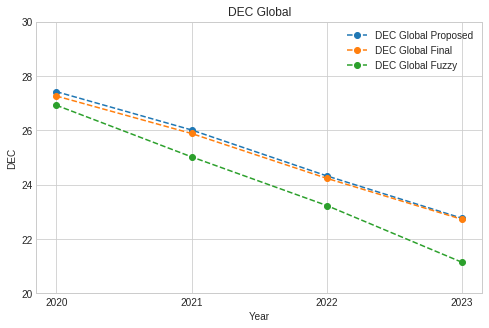

In [ ]:
print('Conjuntos interligados')
display(df_progression[df_progression['Localizacao'] == 1][['Conjunto','Localizacao',f'{indicator}L_V0'] + target_columns].head(10))
print('')
print('Conjuntos isolados')
display(df_progression[df_progression['Localizacao'] == 2][['Conjunto','Localizacao',f'{indicator}L_V0'] + target_columns].tail(40))
dec_proposed = [27.42,26.01, 24.32, 22.76 ]
dec_final = [27.26,25.88,24.23,22.72]

fec_proposed = [21.99, 20.53, 18.95, 17.51 ]
fec_final = [22.00, 20.52, 18.99, 17.43]

compare_indicator_progression_with_real(
    df_progression,
    progression_years,
    indicator_proposed = dec_proposed,
    indicator_final = dec_final,
    indicator_label = indicator,
    y_limit = ( 20,30)
)